In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
import scipy

In [3]:
%matplotlib inline

In [ ]:
http://wiki.ljp.upmc.fr/zebrain/

# Loading the Data

In [78]:
from Helper_Functions.accessing_data import h5tree_view

In [79]:
filepath = "content/banyuls_data/spontaneous_fish1.h5"

In [80]:
file = h5py.File(filepath, "r")
h5tree_view(file)

. content/banyuls_data/spontaneous_fish1.h5
├── 📁brain
│   ├── 🔢coordinates ⚙️(3, 54334)float32
│   │   ├── 🏷️reference brain = `zbrain atlas`
│   │   ├── 🏷️space = `RPS`
│   │   └── 🏷️unit = `mm`
│   ├── 🔢fluorescence ⚙️(5553, 54334)float32
│   ├── 🔢regions ⚙️(294, 54334)uint8
│   │   └── 🏷️origin = `zbrain atlas`
│   ├── 🔢spikes ⚙️(5553, 54334)uint8
│   ├── 🔢times ⚙️(5553, 1)float32
│   │   └── 🏷️unit = `s`


In [81]:
coords = file["/brain/coordinates"][:]
#dffs = file["/brain/fluorescence"][600:, :]
#regions = file["/brain/regions"][:]

# Investigating the data

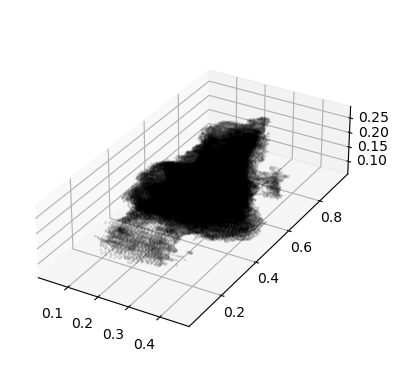

In [458]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(coords[0], coords[1], coords[2], s=1, color="k", alpha=0.1)
ax.set_aspect('equal')

In [459]:
def ortho_axes(coords, figsize=5):
    size = coords.ptp(axis=1)
    W = size[0] + size[2]
    H = size[1] + size[2]
    fig = plt.figure(
        figsize=(figsize*W/H,figsize),
        constrained_layout=True
    )
    gs = GridSpec(
        2, 2, 
        figure=fig,
        #top=W/H,
        left=0,
        right=0.1,
        width_ratios=[size[0]/W, size[2]/W], 
        height_ratios=[size[1]/H, size[2]/H], 
        wspace=0, hspace=0
    )
    ax_xy = fig.add_subplot(gs[0], xticks=[], yticks=[])
    ax_yz = fig.add_subplot(gs[1], sharey=ax_xy, xticks=[], yticks=[])
    ax_xz = fig.add_subplot(gs[2], sharex=ax_xy, xticks=[], yticks=[])
    return fig, (ax_xy, ax_yz, ax_xz)

def ortho_scatter(axes, coords, markersize=1, color="k", alpha=0.1, cmap=None, vmin=None, vmax=None):
    (ax_xy, ax_yz, ax_xz) = axes
    ax_xy.scatter(coords[0], coords[1], s=markersize, c=color, alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_yz.scatter(coords[2], coords[1], s=markersize, c=color, alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_xz.scatter(coords[0], coords[2], s=markersize, c=color, alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)

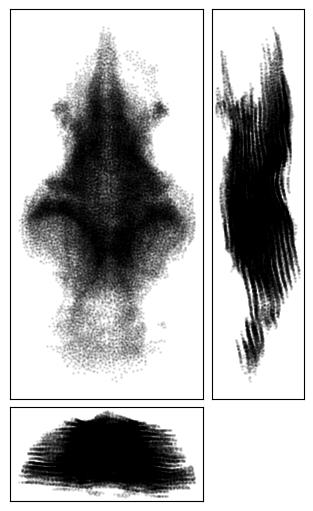

In [460]:
fig, axes = ortho_axes(coords)
ortho_scatter(axes, coords)

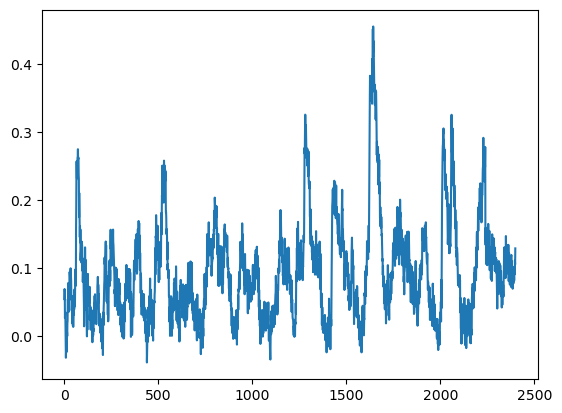

In [461]:
plt.plot(dffs[:,100])

# Kmeans

In [404]:
from sklearn.cluster import KMeans

In [462]:
r = 113
inds = np.where(regions[r]==1)[0]
dff = dffs[:,inds]
dff.shape

(2400, 26471)

In [463]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(dff.T)

/home/mkk/.conda/envs/ibio/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

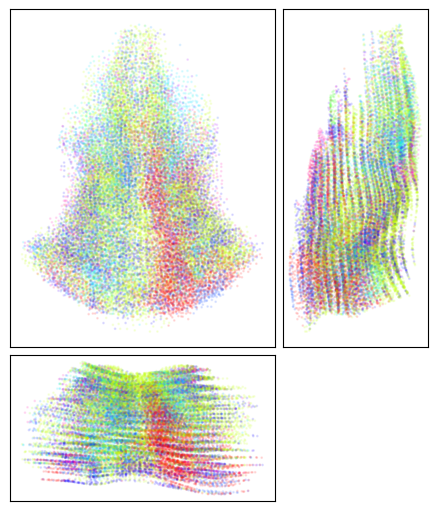

In [473]:
fig, axes = ortho_axes(coords[:,inds])
#ortho_scatter(axes, coords)
ortho_scatter(axes, coords[:,inds], color=kmeans.labels_, alpha=0.1, cmap="hsv")

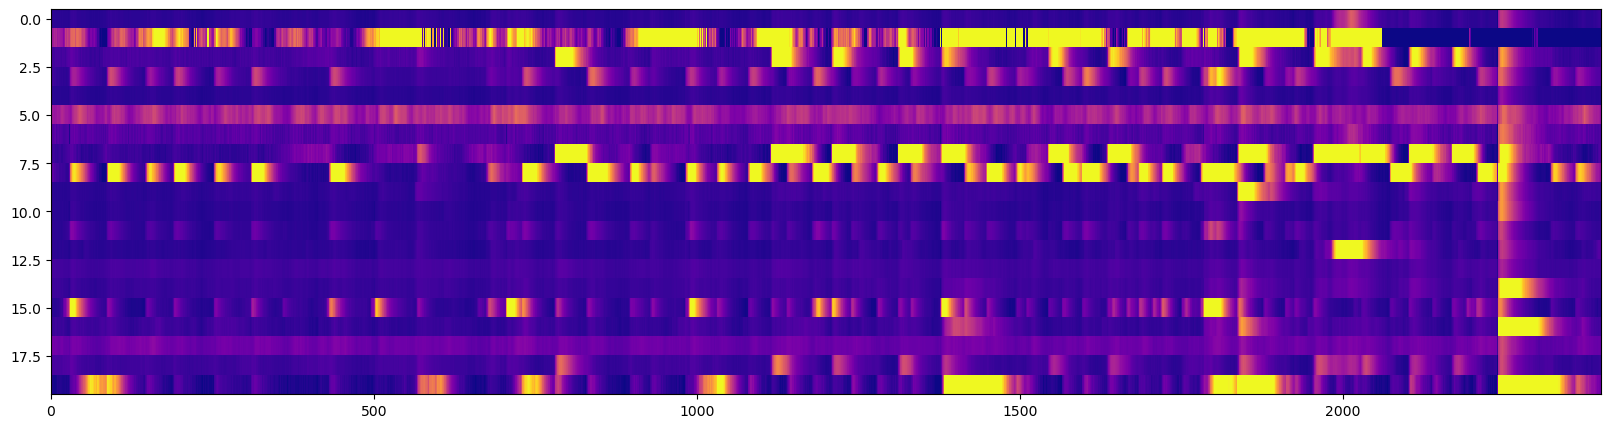

In [475]:
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(kmeans.cluster_centers_, aspect="auto", interpolation="none", cmap="plasma", vmin=0, vmax=0.7)

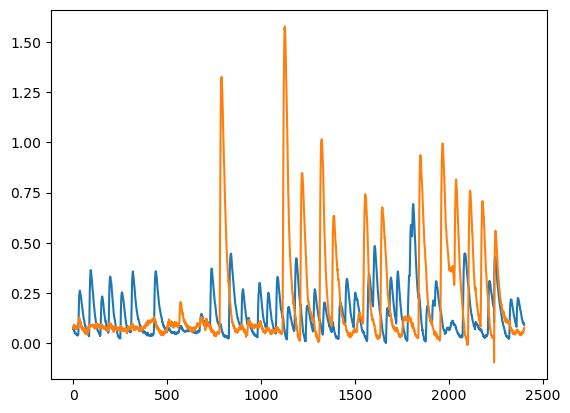

In [476]:
plt.plot(kmeans.cluster_centers_[[3,2]].T)

In [477]:
C = np.corrcoef(kmeans.cluster_centers_)

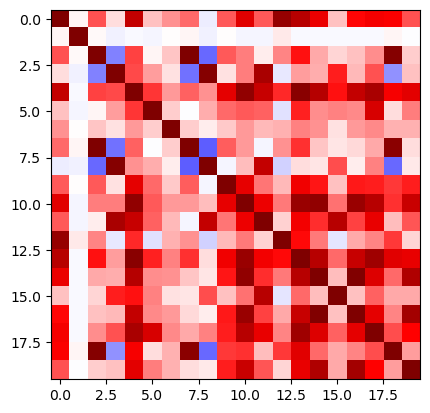

In [478]:
plt.imshow(C, cmap="seismic", vmin=-1, vmax=+1)

In [483]:
Y = kmeans.cluster_centers_[kmeans.labels_].T

In [484]:
Y.shape

(2400, 26471)

In [490]:
from matplotlib.colors import LogNorm

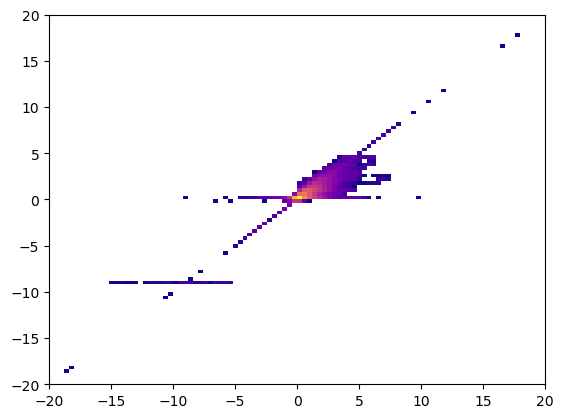

In [509]:
plt.hist2d(dff.ravel(), Y.ravel(), bins=100, cmap="plasma", norm=LogNorm(), range=[[-20,+20],[-20,+20]]);

# Activity per region with PCA

In [387]:
r = 130 # 93, 113, 65

In [388]:
inds = np.where(regions[r]==1)[0]

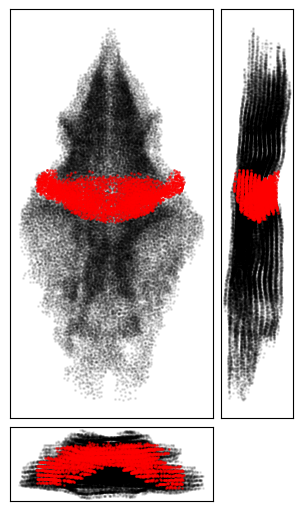

In [389]:
fig, axes = ortho_axes(coords)
ortho_scatter(axes, coords)
ortho_scatter(axes, coords[:,inds], color="red", alpha=0.5)

In [390]:
dff = dffs[:,inds]
dff.shape

(2400, 3265)

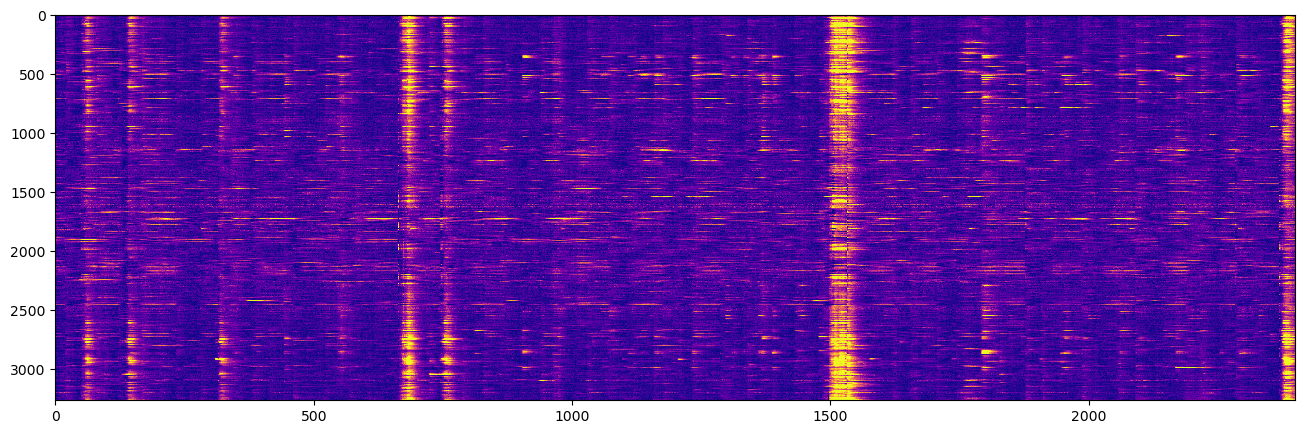

In [391]:
fig, ax = plt.subplots(figsize=(16,5))
ax.imshow(dff.T, aspect="auto", cmap="plasma", vmin=0, vmax=0.5, interpolation="none")

In [392]:
from sklearn.decomposition import PCA, FastICA

In [393]:
pca = PCA(n_components=4)
pca.fit(dff)
Y = pca.transform(dff)

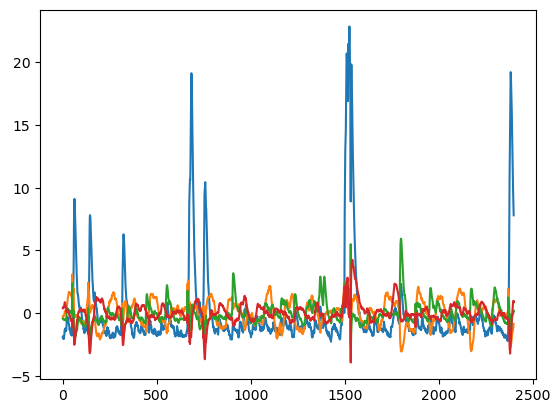

In [394]:
plt.plot(Y)
#plt.ylim(-200,200)

In [395]:
pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.573276  , 0.04511085, 0.03216833, 0.02853533], dtype=float32),
 0.67909044)

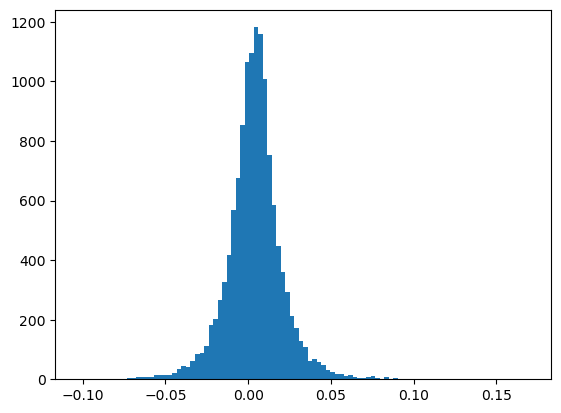

In [396]:
plt.hist(pca.components_.ravel(), bins=100);

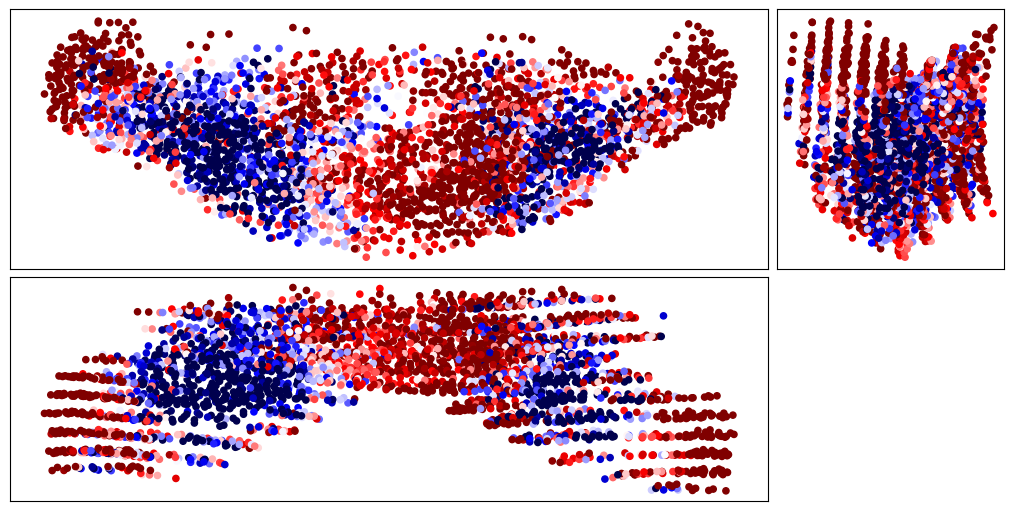

In [403]:
fig, axes = ortho_axes(coords[:,inds])
#ortho_scatter(axes, coords, alpha=0.01)
ortho_scatter(axes, coords[:,inds], color=pca.components_[3], cmap="seismic", vmin=-0.01, vmax=+0.01, alpha=1, markersize=20)

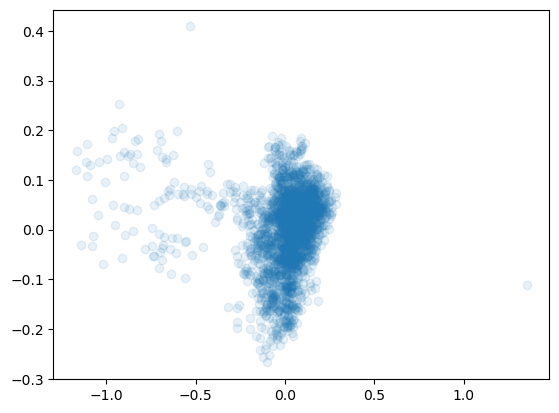

In [372]:
plt.scatter(Y[:,0], Y[:,1], alpha=0.1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [97]:
%matplotlib qt

In [235]:
from matplotlib.figure import Figure
size = coords.ptp(axis=1)
W = size[0] + size[2]
H = size[1] + size[2]

from matplotlib.gridspec import GridSpec
class OrthoAxes:
    def __init__(self, fig, interactive=True):
        gs = GridSpec(
            2, 2, 
            figure=fig,
            #top=W/H,
            #left=0,
            #right=0.1,
            width_ratios=[size[0]/W, size[2]/W], 
            height_ratios=[size[1]/H, size[2]/H], 
            wspace=0, hspace=0
        )
        self.ax_xy = fig.add_subplot(gs[0], xticks=[], yticks=[])
        self.ax_yz = fig.add_subplot(gs[1], sharey=self.ax_xy, xticks=[], yticks=[])
        self.ax_xz = fig.add_subplot(gs[2], sharex=self.ax_xy, xticks=[], yticks=[])
        self._axs = [self.ax_xy, self.ax_yz, self.ax_xz]

        self._interactive = interactive
        if self._interactive:
            self._cursor = np.array([0,0,0], dtype=np.float_)
            self._sets = []
            self._h_lines, self._v_lines = [], []
            for ax in self._axs:
                self._h_lines.append(ax.axhline(color='k', lw=0.8, ls='--'))
                self._v_lines.append(ax.axvline(color='k', lw=0.8, ls='--'))
            fig.canvas.mpl_connect('button_press_event', self._on_mouse_clic)

    def _on_mouse_clic(self, event):
        x, y = event.xdata, event.ydata
        a = self._find_axnb(event.inaxes)
        if a==0:
            self._cursor[0] = x
            self._cursor[1] = y
        elif a==1:
            self._cursor[1] = y
            self._cursor[2] = x
        elif a==2:
            self._cursor[0] = x
            self._cursor[2] = y
        self._draw_cursor()
            
    def _draw_cursor(self):
        x,y,z = self._cursor
        self._v_lines[0].set_xdata([x])
        self._h_lines[0].set_ydata([y])
        self._v_lines[1].set_xdata([z])
        self._h_lines[1].set_ydata([y])
        self._v_lines[2].set_xdata([x])
        self._h_lines[2].set_ydata([z])
        for ax in self._axs:
            ax.figure.canvas.draw()
            
    def _find_axnb(self, ax):
        for i,a in enumerate(self._axs):
            if ax==a:
                return i
        return None
    
    def scatter(self, XYZ, save_set=True, **kwargs):
        self.ax_xy.scatter(XYZ[0],XYZ[1], **kwargs)
        self.ax_yz.scatter(XYZ[2],XYZ[1], **kwargs)
        self.ax_xz.scatter(XYZ[0],XYZ[2], **kwargs)
        if save_set and self._interactive:
            self._sets.append(XYZ)

In [237]:
figsize=10
fig = plt.figure(figsize=(figsize*W/H,figsize))
ortho = OrthoAxes(fig, interactive=True)
ortho.scatter(coords, color="k", alpha=0.05, s=1)

In [201]:
def _find_closest():
    dists = np.sqrt(((coords - ortho._cursor[:,np.newaxis])**2).sum(axis=0))
    i = np.argmin(dists)
    return i, dists[i]
def _find_closest_per_set():
    

In [225]:
_find_closest()

(368, 0.005243619140094312)

In [204]:
f'{ortho._sets[0]=}'.partition('=')[0]

'ortho._sets[0]'

In [230]:
get_variable_name(ortho._sets[0])

In [223]:
def get_variable_name(variable):
    for name in globals():
        if id(globals()[name]) == id(variable):
            return name
    return None

In [104]:
fig.canvas.

Signature: fig.canvas.mpl_connect(s, func)
Docstring:
Bind function *func* to event *s*.

Parameters
----------
s : str
    One of the following events ids:

    - 'button_press_event'
    - 'button_release_event'
    - 'draw_event'
    - 'key_press_event'
    - 'key_release_event'
    - 'motion_notify_event'
    - 'pick_event'
    - 'resize_event'
    - 'scroll_event'
    - 'figure_enter_event',
    - 'figure_leave_event',
    - 'axes_enter_event',
    - 'axes_leave_event'
    - 'close_event'.

func : callable
    The callback function to be executed, which must have the
    signature::

        def func(event: Event) -> Any

    For the location events (button and key press/release), if the
    mouse is over the Axes, the ``inaxes`` attribute of the event will
    be set to the `~matplotlib.axes.Axes` the event occurs is over, and
    additionally, the variables ``xdata`` and ``ydata`` attributes will
    be set to the mouse location in data coordinates.  See `.KeyEvent`
    and `.Mo